In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from scipy.integrate import solve_ivp
from scipy import optimize
from scipy import linalg
import scipy.optimize as so

In [2]:
# Unless specified otherwise, s will refer to the array representing the susceptible populations. Similarly, for i and r.

In [3]:
n = np.array([0.5, 0.35, 0.15]) #Define the sizes of sub-populations
gamma = 1 #Recovery rate
b = np.array([[3, 1.25, 2.5], [2.5, 3, 0.9], [1.8, 0.9, 3]])  #Transmission parameters i.e. beta_ij for groups i and j
#b = np.array([[1.5, 1, 2], [2, 0.75, 0.8], [1.5, 0.75, 1.25]])  # Another test case

#Using above parameters, we create the matrix that governs the initial time dynamics of the SIR equations 
def growth_rate(s, b, gamma): #This function returns the growth rate
    B = np.array([b[0]*s[0], b[1]*s[1], b[2]*s[2]])
    M = B - np.eye(3)*gamma #The largest eigenvalue of M is the growth rate of the epidemic
    EV = linalg.eigvals(M)
    gr = np.amax(EV) #Growth rate
    return gr 

In [4]:
def FS3(x, b, n, g): ## This function gives the final size using the above defined parameters
    return [x[0] - n[0]*(1-np.exp(-np.sum(b[0]*x/g))), x[1] - n[1]*(1-np.exp(-np.sum(b[1]*x/g))),
     x[2] - n[2]*(1-np.exp(-np.sum(b[2]*x/g)))]

In [5]:
root = so.root(FS3, [0.9, 0.9, 0.9], args = (b, n, gamma)) #Using a numerical solver to find the final size
FS_ord = root.x #The three final sizes
print('Final Size for the ordinary epidemic: ', FS_ord) 

Final Size for the ordinary epidemic:  [0.42899141 0.30690016 0.11248311]


In [6]:
def LCFS(a, x): #Expression for linear combination of final sizes 'x'.
    return np.sum(a*x) #a and x are arrays with three elements

C:\Users\Pratyush\Miniconda3\envs\LTURA\lib\site-packages\scipy\optimize\_numdiff.py:579: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
C:\Users\Pratyush\Miniconda3\envs\LTURA\lib\site-packages\scipy\optimize\slsqp.py:427: ComplexWarning: Casting complex values to real discards the imaginary part
  slsqp(m, meq, x, xl, xu, fx, c, g, a, acc, majiter, mode, w, jw,


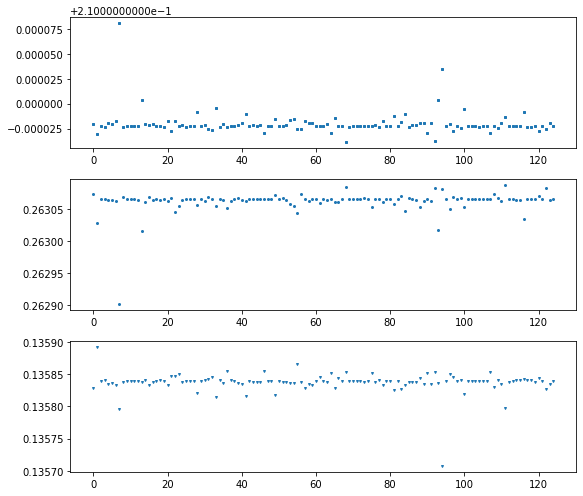

In [21]:
constraint = optimize.NonlinearConstraint(lambda x: growth_rate(n-x, b, gamma), lb=0, ub=0) #since x is final size, we pass the s array = n-x to the growth rate function
#A = np.array([1, 0, 0]) ## The coefficients of the linear combination expression. This particular LC minimizes the epidemic size in first group only.
A = np.array([1, 1, 1]) ## The coefficients of the linear combination expression. This particular LC minimizes the overall epidemic size
A = np.array([2, 1, 1])
n_trials = 125
solns = []
for j in range(n_trials):
    optimize_ic = np.random.rand(3)*n
    min_size = optimize.minimize(LCFS, x0 = optimize_ic, args = (A), constraints = (constraint), bounds = [(0, n[0]), (0, n[1]), (0, n[2])]) ## The solver used is SLSQP
    #print(min_size.x, min_size.success)
    if min_size.success == True:
        solns.append(min_size.x)
solns = np.array(solns).T
#print(solns)
fig, ax = plt.subplots(3, 1, figsize = (8, 7))
ax[0].plot(solns[0], marker = 's', lw = 0, markersize = 2)
ax[1].plot(solns[1], marker = 'o', lw = 0, markersize = 2)
ax[2].plot(solns[2], marker = 'v', lw = 0, markersize = 2) 
fig.tight_layout()
#print(min_size) #Prints the full details of the solution. min_size.x gives the r array
#print('Optimal solution: \ns =', n - min_size.x) #The required values of s, for herd immunity

In [22]:
min_size ##Simply use the last of the array, since we see that only one final root is obtained from multiple initial roots.

     fun: 0.8188597166546767
     jac: array([2., 1., 1.])
 message: 'Optimization terminated successfully'
    nfev: 29
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.20997712, 0.26306598, 0.1358395 ])

In [23]:
## Since we have three groups, we have a surface of herd immunity threshold given by (s0, s1, s2)
## The above obtained optimal solution says that 
# So, we select a curve from the surface in which s2 = (1-0.2)*n[2] and scan the parameter space for s0 and s1
s0, s1, s2 = np.arange(0, n[0]+0.005, 0.005), np.arange(0, n[1]+0.005, 0.005), n[2] - min_size.x[2] ##Fix the third group 's' value and scan the other two 
growth_rate_list = [] #List that stores values for the scatter plot of growth rate we will make next
[growth_rate_list.append([x, y, growth_rate([x, y, s2], b, gamma)]) for x in s0 for y in s1]; #scans s0 and s1 and computes growth rate
growth_rate_list = np.array(growth_rate_list).T
thresh = np.where((growth_rate_list[2]<0.005) & (growth_rate_list[2]>-0.005))[0] #Looks for growth rate = 0 i.e. threshold

# LCFS_list = [] #List that stores values of the LCFS function 
# [LCFS_list.append([x, y, LCFS(A, n-np.array([x, y, s2]))]) for x in s0 for y in s1]; #scans s0 and s1 and computes LCFS
# LCFS_list = np.array(LCFS_list).T



C:\Users\Pratyush\Miniconda3\envs\LTURA\lib\site-packages\numpy\core\_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\Pratyush\Miniconda3\envs\LTURA\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


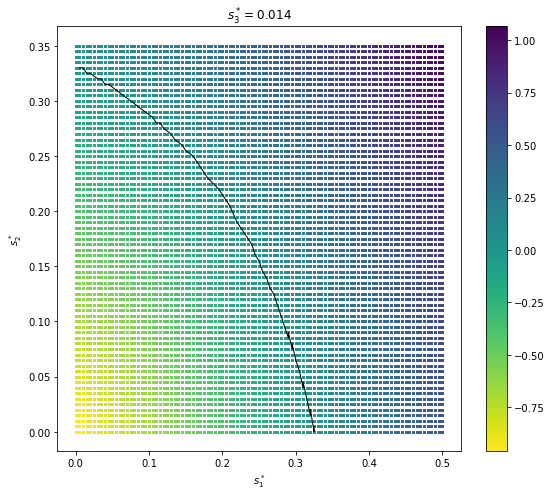

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (8, 7)) 
im1 = ax.scatter(growth_rate_list[0], growth_rate_list[1], c = growth_rate_list[2], s = 4, marker = 's', cmap = 'viridis_r')
ax.plot(growth_rate_list[0][thresh], growth_rate_list[1][thresh], c = 'k', lw = 1) ##From this curve, we will pick a point for the next simulation
fig.colorbar(im1, ax=ax)
#im2 = ax[1].scatter(LCFS_list[0], LCFS_list[1], c = LCFS_list[2], s = 4, marker = 's')
#fig.colorbar(im2, ax=ax[1])
ax.set_xlabel(r'$s_1^*$')
ax.set_ylabel(r'$s_2^*$')
ax.set_title(r'$s_3^* = %.3f$'%s2)
fig.tight_layout()

In [25]:
# Original transmission matrix is 
# b11, b12, b13; 
# b21, b22, b23;
# b31, b32, b33;
# b11 is the rate at which an individual in group 1 infects another individual in group 1
# b12 is the rate at which an individual in group 2 infects another individual in group 1 and so on....

# We assume an intervention of a specific kind, leading to a new matrix: 
# b11*(1-c1), b12*(1-c1), b13*(1-c1); 
# b21*(1-c2), b22*(1-c2), b23*(1-c2);
# b31*(1-c3), b32*(1-c3), b33*(1-c3);
# For the time being, we call this TYPE I intervention. 

# Now, the NGM is just the above matrix divided by gamma (recovery rate).

# The final size relations make use of this NGM. So, we choose our required final sizes, and solve for c1, c2 and c3
# We will build on this further to include other types of interventions.

In [26]:
##Pick a point from the above plot that is on the herd immunity line, or even in the negative region.
s_HI = n- min_size.x ## 
r_HI = n - s_HI ## This will be the final size that we will aim for during the intervention period.
c = np.array([1 + np.log(1-r_HI[0]/n[0])/np.sum(b[0]*r_HI),
 1 + np.log(1-r_HI[1]/n[1])/np.sum(b[1]*r_HI), 1 + np.log(1-r_HI[2]/n[2])/np.sum(b[2]*r_HI)])
b_c = np.array([b[0]*(1-c[0]), b[1]*(1-c[1]), b[2]*(1-c[2])])  ## The new transmission matrix / see above markdown cell
root = so.root(FS3, [0.9, 0.9, 0.9], args = (b_c, n, gamma))
print('b = \n', b)
print('c = ', c)
print('b_c = \n', b_c)
print('Intervention, Final Size: ', root.x) ##Verifying the final size

b = 
 [[3.   1.25 2.5 ]
 [2.5  3.   0.9 ]
 [1.8  0.9  3.  ]]
c =  [ 0.58051142  0.03036248 -1.30883786]
b_c = 
 [[1.25846574 0.52436073 1.04872145]
 [2.4240938  2.90891256 0.87267377]
 [4.15590815 2.07795407 6.92651358]]
Intervention, Final Size:  [0.20997712 0.26306598 0.1358395 ]


In [27]:
def SIR3(t, X, b, g): ##Define the dynamical equations for SIR model with 3 groups and arbitrary transmission
    S = X[0:3]
    I = X[3:6]
    R = X[6:9]
    return np.array([-S[0]*(b[0, 0]*I[0] + b[0, 1]*I[1] + b[0, 2]*I[2]), 
    -S[1]*(b[1, 0]*I[0] + b[1, 1]*I[1] + b[1, 2]*I[2]), 
    -S[2]*(b[2, 0]*I[0] + b[2, 1]*I[1] + b[2, 2]*I[2]),
    S[0]*(b[0, 0]*I[0] + b[0, 1]*I[1] + b[0, 2]*I[2]) - g*I[0], 
    S[1]*(b[1, 0]*I[0] + b[1, 1]*I[1] + b[1, 2]*I[2]) - g*I[1], 
    S[2]*(b[2, 0]*I[0] + b[2, 1]*I[1] + b[2, 2]*I[2]) - g*I[2],
    g*I[0], 
    g*I[1],
    g*I[2]])

In [32]:
eps_i = 0.005 ## Threshold for i(t) at which intervention is imposed
eps_f = 0.5*1e-3 ## Threshold for i(t) below which intervention is released
ti = 0
tf = 80
dt = 0.05
T = np.arange(ti, tf, dt)
X_init = [n[0] - 1/3*1e-3, n[1] - 1/3*1e-3, n[2] - 1/3*1e-3, 1/3*1e-3, 1/3*1e-3, 1/3*1e-3, 0, 0, 0] # Initial conditions
# 1/3*1e-3 is i(0) for each of the groups.

In [33]:
SOL_ord = solve_ivp(SIR3, [ti, tf], X_init, t_eval = T, args = (b, gamma)) # The ordinary trajectory (without intervention)
t_int_idx = np.where(SOL_ord.y[3]+SOL_ord.y[4]+SOL_ord.y[5]-eps_i>=0)[0][0] ##Index value of time at which i(t) crossing eps_i
t_int = T[t_int_idx] ## Time at which i(t) crosses eps_i
X_init_int = SOL_ord.y[:, t_int_idx] ## The initial conditions for the intervention

In [34]:
## Now we implement the intervention
SOL_int = solve_ivp(SIR3, [t_int, tf], X_init_int, t_eval = np.arange(t_int, tf, dt), args = (b_c, gamma)) 
t_rel_idx = np.where(SOL_int.y[3] + SOL_int.y[4] + SOL_int.y[5] < eps_f)[0][0] ## Index value of time where i(t) reaching eps_f
t_rel = SOL_int.t[t_rel_idx]  ## Time at which i(t) crosses eps_f, and intervention is released
X_init_rel = SOL_int.y[:, t_rel_idx] ##Initial conditions for releasing the interventions
SOL_rel = solve_ivp(SIR3, [t_rel, tf], X_init_rel, t_eval = np.arange(t_rel, tf-dt, dt), args = (b, gamma)) #Trajectory post intervention

Size of the groups:  [0.5  0.35 0.15]
Final Sizes for the ordinary epidemic:  [0.42899141 0.30690016 0.11248311] ; Total:  0.8483746690447618
Herd Immunity Point: s =  [0.29002288 0.08693402 0.0141605 ]
Expected final size due to intervention: r =  [0.20997712 0.26306598 0.1358395 ] ; Total:  0.6088825984380635
Observed final size due to intervention: r =  [0.2226228  0.2668823  0.13625153] ; Total:  0.6257566380007168
Details of the figure: dotted line is the original trajectory, dashed line is the intervention, orindary line is post intervention


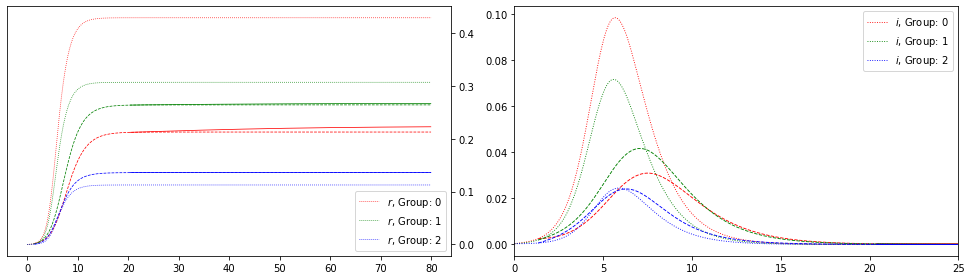

In [35]:
fig, axs = plt.subplots(1, 2, figsize = (17*0.8, 5*0.8))
#plt.suptitle(r'$\beta: %.2f$, $\gamma: %.2f$, $c: %.3f$'%(beta, gamma, c))

clrs = ['r', 'g', 'b']
for j, idx in enumerate([6, 7, 8]):
    axs[0].plot(T, SOL_ord.y[idx].T, c = clrs[j], ls = ':', label = r'$r$, Group: %d'%j, lw = 0.75)
    axs[0].plot(SOL_int.t, SOL_int.y[idx].T, c = clrs[j], ls = '--', lw = 0.75)
    axs[0].plot(SOL_rel.t, SOL_rel.y[idx].T, c = clrs[j], ls = '-', lw = 0.75)
# for j, idx in enumerate([0, 1, 2]):
#     axs[0].plot(T, SOL_ord.y[idx].T, c = clrs[j], ls = ':', label = r'$s$, Group: %d'%j, lw = 0.75)
#     axs[0].plot(SOL_int.t, SOL_int.y[idx].T, c = clrs[j], ls = '--', lw = 0.75)
#     axs[0].plot(SOL_rel.t, SOL_rel.y[idx].T, c = clrs[j], ls = '-', lw = 0.75)
for j, idx in enumerate([3, 4, 5]):
    axs[1].plot(T, SOL_ord.y[idx].T, c = clrs[j], ls = ':', label = r'$i$, Group: %d'%j, lw = 0.9)
    axs[1].plot(SOL_int.t, SOL_int.y[idx].T, c = clrs[j], ls = '--', lw = 0.9)
    axs[1].plot(SOL_rel.t, SOL_rel.y[idx].T, c = clrs[j], ls = '-', lw = 0.9)

axs[0].yaxis.tick_right()
axs[0].legend()
axs[1].legend()
#axs[0].set_xlim(0, 25)
axs[1].set_xlim(0, 25)
fig.tight_layout()

print('Size of the groups: ', n)
print('Final Sizes for the ordinary epidemic: ', FS_ord, '; Total: ', np.sum(FS_ord))
print('Herd Immunity Point: s = ', s_HI)
print('Expected final size due to intervention: r = ', r_HI, '; Total: ', np.sum(r_HI))
print('Observed final size due to intervention: r = ', SOL_rel.y[6:9, -1], '; Total: ', np.sum(SOL_rel.y[6:9, -1]))
print('Details of the figure: dotted line is the original trajectory, dashed line is the intervention, orindary line is post intervention')